In [53]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import liana as li
import matplotlib.pyplot as plt

def load_prep_slide(path, slide, add_sample_name=False, min_genes = 400, bandwidth=150, cutoff=0.1, set_diag=True, **kwargs):
    adata = sc.read_h5ad(os.path.join(path, slide))
    
    if add_sample_name:
        indeces = [f"{slide.split('.')[0]}-{i}" for i in adata.obs.index]
        adata.obs.index = indeces
        adata.obsm['compositions'].index = indeces
    
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=5)
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    li.ut.spatial_neighbors(adata, bandwidth=bandwidth, cutoff=cutoff, set_diag=set_diag, **kwargs)
    
    return adata

In [54]:
os.chdir("/Users/ricardoramirez/Dropbox/PostDoc/Research/Fibrosis_Weizmann/")
data_dir = os.path.join('data', 'visium_data_py')
dataset_names = [f for f in os.listdir(data_dir) if f.endswith('.h5ad')]
metadata = pd.read_csv(os.path.join("data", "visium_meta.csv")).set_index('slide_name')
group_dict = {'group_1': 'Myogenic', 'group_2':'Ischemic', 'group_3': 'Fibrotic'}
#rename_dict = {'Myogenic': 'Myogenic \n (n=14)', 'Ischemic':'Ischemic \n (n=9)', 'Fibrotic': 'Fibrotic \n (n=5)'}
condition_key = 'patient_group'
metadata['patient_group'] = metadata['patient_group'].map(group_dict)

In [59]:
# Importing annotations of myofibroblasts
myofib_scores = pd.read_csv("./results/myofib_sptl_spotscores.csv")[["slide_id", "barcode", "module_score"]]
myofib_scores = myofib_scores.rename(columns={'module_score': 'Myofib'})
myofib_scores['barcode'] = myofib_scores['slide_id'].str.cat(myofib_scores['barcode'], sep='-')
myofib_scores = myofib_scores.set_index('barcode')

In [62]:
# Min-Max scaling of column 'A'
min_val = myofib_scores['Myofib'].min()
max_val = myofib_scores['Myofib'].max()
myofib_scores['Myofib'] = (myofib_scores['Myofib'] - min_val) / (max_val - min_val)

dataset_name: Visium_2_CK280.h5ad; ACH0021


... storing 'slide_id' as categorical


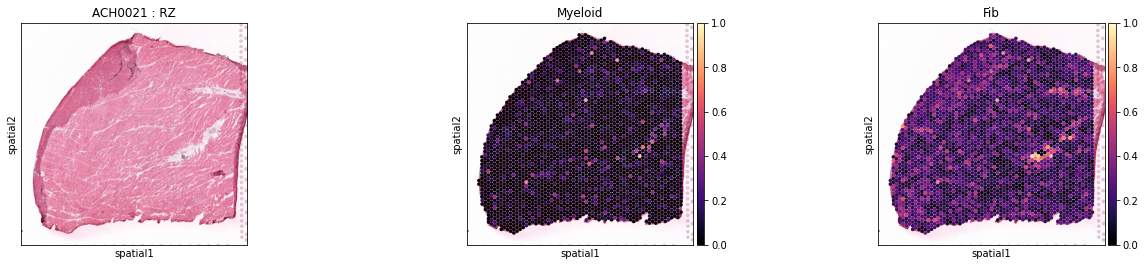

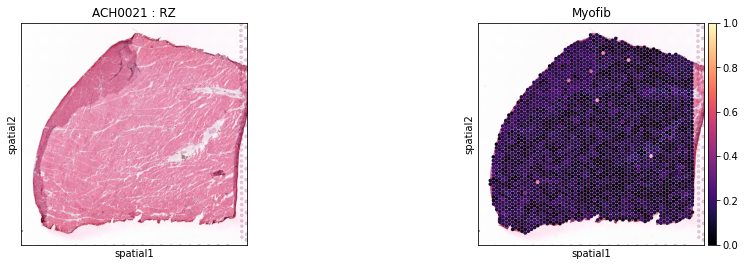

dataset_name: Visium_20_CK298.h5ad; ACH0015


... storing 'slide_id' as categorical


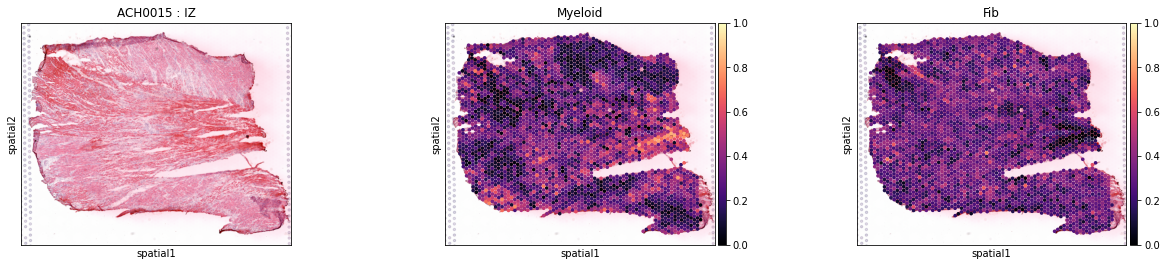

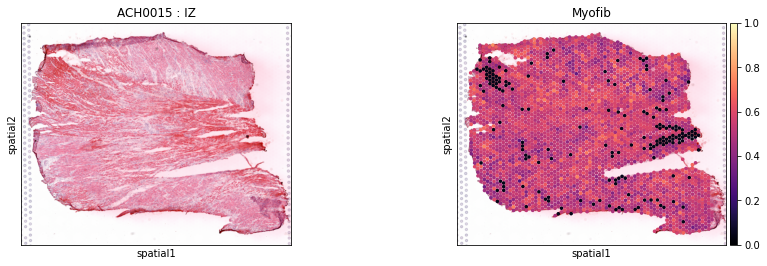

dataset_name: Visium_6_CK284.h5ad; ACH0023


... storing 'slide_id' as categorical


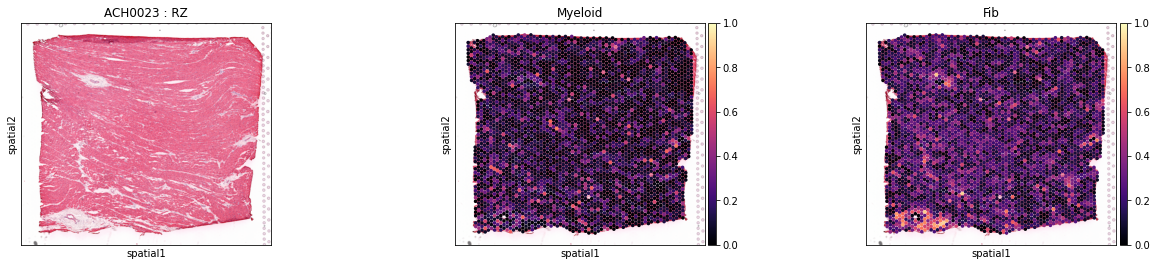

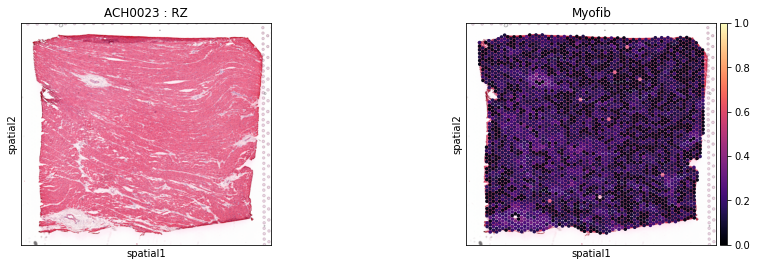

dataset_name: Visium_4_CK282.h5ad; ACH004


... storing 'slide_id' as categorical


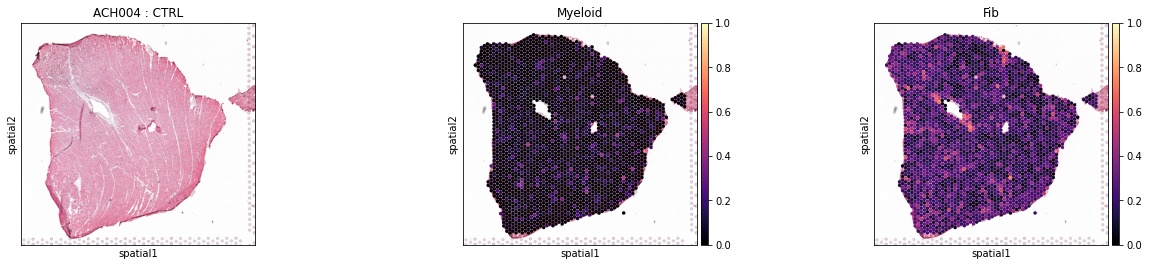

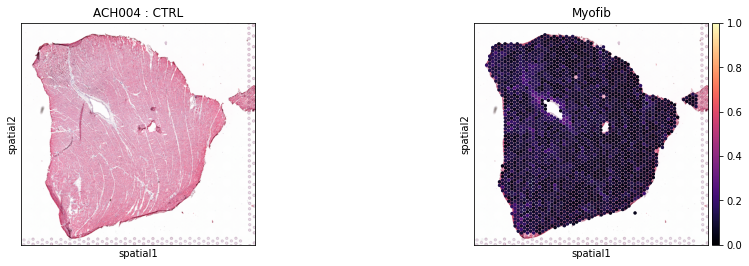

dataset_name: Visium_19_CK297.h5ad; ACH0013


... storing 'slide_id' as categorical


In [65]:
for dataset_name in dataset_names:
   sample_id = metadata.loc[dataset_name.replace('.h5ad', ''), 'hca_sample_id']
   patient_grup = metadata.loc[dataset_name.replace('.h5ad', ''), 'major_labl']
   
   print(f"dataset_name: {dataset_name}; {sample_id}")
   adata = load_prep_slide(data_dir, dataset_name, add_sample_name=True)

   adata.obs = adata.obs.join(adata.obsm['compositions'])
   adata.obs = adata.obs.join(myofib_scores, how="left")
   
   sc.pl.spatial(adata, color=[None, 'Myeloid', 'Fib'], 
                       cmap='magma', size=1.5, 
                       title=f"{sample_id} : {patient_grup}", 
                       save=f"{sample_id}_comps.pdf",
                       vmin = 0, vmax = 1)
   
   sc.pl.spatial(adata, color=[None, 'Myofib'], 
                       cmap='magma', size=1.5, 
                       title=f"{sample_id} : {patient_grup}", 
                       save=f"{sample_id}_myofib.pdf",
                       vmin = 0, vmax = 1)
   
   